In [397]:
!pip install langchain-groq
!pip install --upgrade -U langchain-core langchain-groq langchain_groq langchain

In [398]:
!pip install langchain_community

In [399]:
from langchain_groq import ChatGroq

from dotenv import load_dotenv
import os
load_dotenv()
groq_api_key = os.getenv("groq_api_key")
llm = ChatGroq(model_name="llama-3.1-8b-instant", api_key=groq_api_key)

Importing all the Libraries

In [400]:
from pydantic import BaseModel
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate
from langgraph.graph import StateGraph, START, END

Defining the State Object

In [401]:
class State(BaseModel):
    input: str
    route: str | None = None
    output: str | None = None

Defining the State Graph

In [402]:
graph = StateGraph(State)

In [403]:
from langchain_core.output_parsers import StrOutputParser

system_prompt = """
You are a helpful assistant that can answer questions about Mental Health.
"""

user_question = "What are some effective strategies for managing anxiety and stress in daily life?"

human_prompt = f"""
{user_question}
"""

from langchain_core.prompts import ChatPromptTemplate , SystemMessagePromptTemplate , HumanMessagePromptTemplate

system_message_prompt = SystemMessagePromptTemplate.from_template(system_prompt)

human_message_prompt = HumanMessagePromptTemplate.from_template(human_prompt)

prompt = ChatPromptTemplate.from_messages([system_message_prompt , human_message_prompt])

chain = prompt | llm | StrOutputParser()

chain.invoke({"user_question":user_question})

'Managing anxiety and stress is essential for maintaining good mental health and overall well-being. Here are some effective strategies for managing anxiety and stress in daily life:\n\n1. **Mindfulness and Meditation**: Regular mindfulness practice can help calm the mind, reduce anxiety, and increase focus. You can start with guided meditations or apps like Headspace, Calm, or Insight Timer.\n\n2. **Exercise and Physical Activity**: Regular exercise can help reduce anxiety and stress by releasing endorphins, also known as "feel-good" hormones. Engage in activities like walking, running, yoga, or any other exercise that you enjoy.\n\n3. **Deep Breathing Techniques**: Deep breathing can help calm the nervous system and reduce anxiety. Try inhaling for a count of four, holding your breath for a count of four, and exhaling for a count of four.\n\n4. **Grounding Techniques**: Grounding techniques can help you focus on the present moment and distract you from anxious thoughts. Try activitie

In [404]:
def router_agent(state: State) -> State:
    system_prompt = (
        "You are a routing assistant for a campus mental health support system. "
        "Analyze the user's input and respond with EXACTLY ONE of the following labels: 'RAG', 'RISK', 'QUERY', or 'PEER'. "
        "Do NOT include any other text, explanations, or punctuation. Return only the label.\n\n"
        "Categories:\n"
        "- RAG: Informational queries about mental health, wellness, or coping strategies "
        "(e.g., 'What is depression?', 'Remedies for anxiety', 'What should I do if I am feeling depressed?').\n"
        "- RISK: Inputs indicating suicide, distress, crisis, or potential self-harm "
        "(e.g., 'I feel hopeless and am thinking of ending my life', 'I am planning to suicide', 'I am done with my life').\n"
        "- QUERY: Inputs asking about helplines, counselor contact info, or campus mental health resources "
        "(e.g., 'Where can I get counseling?', 'How can I meet Professor Smith for guidance?').\n"
        "- PEER: Inputs seeking peer support, community engagement, or group interaction "
        "(e.g., 'I want to connect with others', 'How can I join a support group?').\n\n"
        "Examples:\n"
        "Input: 'What are some remedies for anxiety?' → RAG\n"
        "Input: 'I want to attempt suicide what to do?' → RISK\n"
        "Input: 'Where can I find a counselor on campus?' → QUERY\n"
        "Input: 'I want to join a group to meet people going through similar stuff' → PEER\n"
        "Input: 'I'm feeling really stressed and overwhelmed with exams' → RAG\n"
        "Input: 'I need someone to talk to right now or a group to join' → PEER\n\n"
    )

    user_prompt = state.input

    system_template = SystemMessagePromptTemplate.from_template(system_prompt)
    user_template = HumanMessagePromptTemplate.from_template("{user_prompt}")
    final_template = ChatPromptTemplate.from_messages([system_template, user_template])

    chain = final_template | llm | StrOutputParser()
    result = chain.invoke({"system_prompt": system_prompt.format(user_prompt=user_prompt), "user_prompt": user_prompt})

    route_map = {
        "RAG": "rag_knowledge_agent",
        "RISK": "risk_assessment_agent",
        "QUERY": "support_chat_agent",
        "PEER": "peer_connector_agent"
    }

    # Normalize result and get route
    result = result.strip().upper()

    return State(input=state.input, route=route_map[result], output=None)


In [ ]:
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings

def rag_knowledge_agent(state: State) -> State:
    # Initialize embeddings
    embeddings = OllamaEmbeddings(
        model="nomic-embed-text",
        base_url="http://localhost:11434"
    )

    # Initialize Chroma vector store
    PERSIST_DIRECTORY = "C:\\Users\\kousi\\Documents\\hackathon\\rag\\vectorstore"
    db = Chroma(
        persist_directory=PERSIST_DIRECTORY,
        embedding_function=embeddings
    )

    # Use state.input as the query
    query = state.input
    docs = db.similarity_search(query, k=4)

    # Combine document contents
    answer = ''.join(doc.page_content for doc in docs)

    # Rewrite the answer to be empathetic and supportive
    def rewrite(answer):
        prompt = (
            "You are a compassionate assistant. Rewrite the following information to be empathetic, supportive, "
            "and encouraging, ensuring the tone is warm and non-judgmental. Provide practical advice and acknowledge "
            "the user's feelings. Avoid clinical diagnoses. Return only the rewritten text.\n\n"
            f"Original: {answer}\n\n"
            "Rewritten Answer:"
        )
        # Invoke LLM and extract string content from AIMessage
        rewritten_answer = llm.invoke(prompt)
        # Ensure the output is a string (handles AIMessage object)
        return rewritten_answer.content if hasattr(rewritten_answer, 'content') else str(rewritten_answer)

    output = rewrite(answer)

    return State(input=state.input, route=state.route, output=output)

In [406]:
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import smtplib
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

def risk_assessment_agent(state):
    """
    Sends an email to a counselor based on a student's input indicating potential distress
    and returns a supportive message for the user.

    Args:
        state: An object with 'input' (user's message) and 'route' attributes.

    Returns:
        State: Updated state object with input, route, and output (user_message) attributes.
    """
    # Validate state and input
    if not hasattr(state, 'input') or not hasattr(state, 'route'):
        raise ValueError("State object must have 'input' and 'route' attributes")
    if not state.input or not isinstance(state.input, str):
        raise ValueError("State.input must be a non-empty string")

    # Prepare email content
    email_content = (
        "Subject: Support Needed – Mental Health Check\n\n"
        "Dear Counselor,\n\n"
        "A student has shared the following message indicating potential distress: "
        f"'{state.input}'. They may need your support. Please reach out to them as soon as possible "
        "to offer assistance and ensure their safety. If urgent, consider contacting campus resources "
        "or a crisis hotline (e.g., 988) for immediate support.\n\n"
        "Thank you,\nCampus Support System"
    )

    # Prepare user message (fixed string formatting)
    user_message = (
        "Thank you for sharing. We care about you and want to help. Please reach out to a trusted person, "
        "such as a counselor or friend, or call a crisis hotline like 988 for immediate support."
    )

    # Email configuration
    sender_email = os.getenv("SENDER_EMAIL", "kousikgvs@gmail.com")  # Default for testing
    receiver_email = os.getenv("RECEIVER_EMAIL", "kousikgn@example.com")  # Default for testing
    password = os.getenv("APP_PASSWORD")  # Consistent key naming

    # Validate email credentials
    if not password:
        print("Error: APP_PASSWORD environment variable not set")
        user_message = (
            f"{user_message} (Note: There was an issue sending an email to a support contact, "
            "but you can still reach out to a hotline or counselor.)"
        )
    else:
        # Prepare email
        message = MIMEMultipart()
        message["From"] = sender_email
        message["To"] = receiver_email
        message["Subject"] = "Support Needed – Mental Health Check"
        message.attach(MIMEText(email_content, "plain"))

        # Send email
        try:
            with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
                server.login(sender_email, password)
                server.sendmail(sender_email, receiver_email, message.as_string())
            print("Email sent successfully!")
        except Exception as e:
            print(f"Error sending email: {e}")
            user_message = (
                f"{user_message} (Note: There was an issue sending an email to a support contact, "
                "but you can still reach out to a hotline or counselor.)"
            )

    # Print output for user
    print("risk_assessment_agent output:", user_message)

    # Return updated state (use type(state) to ensure correct class)
    return type(state)(input=state.input, route=state.route, output=user_message)

In [407]:
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain_core.output_parsers import StrOutputParser

def support_chat_agent(state: State) -> State:
    system_prompt = (
        "You are a compassionate and supportive chatbot designed for students seeking mental health assistance. "
        "Provide empathetic, conversational, and non-judgmental responses that acknowledge the user's feelings and offer emotional support. "
        "Encourage positive coping strategies and prioritize user safety. "
        "When the user asks about campus resources, counselors, or helplines (e.g., 'Where can I get counseling?' or 'How can I meet Professor Smith for guidance?'), "
        "provide clear, actionable guidance with specific next steps (e.g., contact details, campus office locations, or helpline numbers). "
        "Avoid clinical diagnoses and keep responses warm, confidential, and supportive. "
        "Return only the response text, without additional explanations or metadata.\n\n"
        "Examples:\n"
        "Input: 'Where can I find a counselor on campus?' → "
        "'I’m here to help you find the support you need. Most campuses have a counseling center, often located in the student health services building. "
        "You can check your university’s website for the counseling center’s contact info or visit during office hours to schedule an appointment. "
        "Would you like tips on how to prepare for your first counseling session?'\n"
        "Input: 'I’m feeling overwhelmed and don’t know where to turn.' → "
        "'I’m so sorry you’re feeling overwhelmed—it’s okay to feel this way sometimes, and you’re not alone. "
        "Try taking a few deep breaths or stepping away for a short walk to clear your mind. "
        "Connecting with a counselor or a trusted friend can also help. Would you like information on campus resources or coping strategies to manage stress?'\n\n"
        "Input: {user_prompt}\n"
        "Output: "
    )
    user_prompt = state.input
    final_template = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template(system_prompt),
        HumanMessagePromptTemplate.from_template("{user_prompt}")
    ])
    chain = final_template | llm | StrOutputParser()
    result = chain.invoke({"system_prompt": system_prompt.format(user_prompt=user_prompt), "user_prompt": user_prompt})
    
    # Ensure result is a string (handles cases where StrOutputParser might not fully convert AIMessage)
    output = result if isinstance(result, str) else getattr(result, 'content', str(result))
    
    # print("support_chat_agent output:", output)  # For debugging
    return State(input=state.input, route=state.route, output=output)

In [408]:
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain_core.output_parsers import StrOutputParser

def peer_connector_agent(state: State) -> State:
    system_prompt = (
        "You are a peer connector agent for a campus mental health support system. "
        "Based on the user's input, suggest actionable ways to connect with peer support groups, student clubs, online forums, or individuals with similar experiences. "
        "Ensure responses are empathetic, inclusive, and sensitive, acknowledging the user’s desire to connect. "
        "Provide specific, practical steps (e.g., checking campus websites, joining specific platforms, or attending events) to engage with these communities. "
        "Keep responses warm, non-judgmental, and encouraging. "
        "Return only the response text, without additional explanations or metadata.\n\n"
        "Examples:\n"
        "Input: 'I want to join a group to meet people going through similar stuff.' → "
        "'I’m so glad you’re looking to connect with others—it’s a brave step! You can check your campus’s student activities website for mental health support groups or clubs focused on wellness. "
        "Many universities also have peer-led groups like Active Minds, which you can join by emailing the student affairs office or attending their next meeting. "
        "Online, platforms like 7 Cups or Reddit’s r/mentalhealth offer supportive communities. Would you like tips on starting conversations in these groups?'\n"
        "Input: 'I need someone to talk to right now or a group to join.' → "
        "'I hear how much you’re seeking connection, and you’re not alone in feeling this way. You can look for campus peer support groups through your university’s counseling center or student union, which often list upcoming meetings. "
        "Online, try joining a forum like The Mighty or a Discord server for mental health support to connect instantly. "
        "Would you like help finding specific campus resources or online communities?'\n\n"
        "Input: {user_prompt}\n"
        "Output: "
    )
    user_prompt = state.input
    final_template = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template(system_prompt),
        HumanMessagePromptTemplate.from_template("{user_prompt}")
    ])
    chain = final_template | llm | StrOutputParser()
    result = chain.invoke({"system_prompt": system_prompt.format(user_prompt=user_prompt), "user_prompt": user_prompt})
    
    # Ensure result is a string (handles cases where StrOutputParser might not fully convert AIMessage)
    output = result if isinstance(result, str) else getattr(result, 'content', str(result))
    
    print("peer_connector_agent output:", output)  # For debugging
    return State(input=state.input, route=state.route, output=output)

In [409]:
def route_next(state: State):
    return state.route  # Must return the node name as string

In [410]:
# Initialize the graph
graph = StateGraph(State)

# Add nodes for each agent
graph.add_node("router_agent", router_agent)
graph.add_node("rag_knowledge_agent", rag_knowledge_agent)
graph.add_node("risk_assessment_agent" , risk_assessment_agent)
graph.add_node("support_chat_agent", support_chat_agent)
graph.add_node("peer_connector_agent", peer_connector_agent)

# Add conditional edges from router_agent

graph.add_conditional_edges(
    "router_agent",
    route_next,
    {
        "rag_knowledge_agent": "rag_knowledge_agent",
        "risk_assessment_agent": "risk_assessment_agent",
        "support_chat_agent": "support_chat_agent",
        "peer_connector_agent": "peer_connector_agent"
    }
)

# Add end edges for each agent
graph.add_edge("rag_knowledge_agent", END)
graph.add_edge("risk_assessment_agent", END)
graph.add_edge("support_chat_agent", END)
graph.add_edge("peer_connector_agent", END)

# Set entry point
graph.set_entry_point("router_agent")

In [411]:
multi_agent_graph = graph.compile()

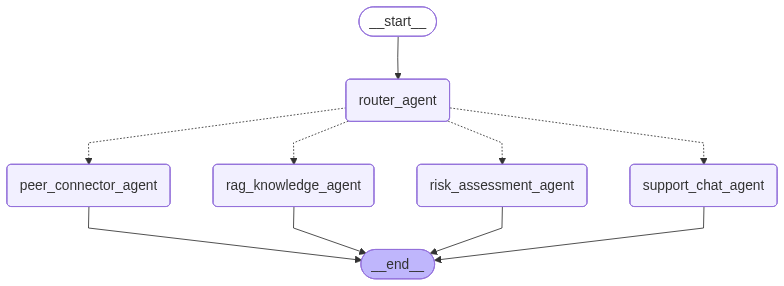

In [412]:
multi_agent_graph

In [413]:
def chat(user_input: str) -> State:
    initial_state = State(input=user_input)
    result = multi_agent_graph.invoke(initial_state)
    return result

In [414]:
# Test with different inputs
test_inputs = [
    "What are some remedies for anxiety?",
    "I'm feeling really stressed and overwhelmed with exams.",
    "I need someone to talk to right now or a group to join ",
    "Where can I find a counselor on campus?",
    "I want to join a group to meet people going through similar stuff.",
    "I want to attempt sucide what to do ?"
]

for input_text in test_inputs:
    response_state = chat(input_text)
    print(response_state)

{'input': 'What are some remedies for anxiety?', 'route': 'rag_knowledge_agent', 'output': "I completely understand that you're feeling overwhelmed and stressed. It's amazing how quickly life can get in the way, isn't it? Don't worry, we're here to help you find ways to manage your stress and feel more balanced.\n\nYou might want to try some simple relaxation techniques to start with. Just taking a few deep breaths, rolling your shoulders, and releasing any physical tension can work wonders. You can also try some progressive relaxation exercises, which involve tensing and releasing different muscle groups. It might feel a bit awkward at first, but trust me, it can be incredibly helpful in calming your body and mind.\n\nAnother great idea is to focus on your breathing. Deep, slow breaths can be incredibly soothing, and you can even try some guided breathing exercises to help you relax. You might also find that smiling and laughing can help shift your mood and reduce stress. It's amazing